###  This analysis will dig into the school test data a little deeper.  It will narrow the scope by examing only the test results the 3rd grade.  I will examine the data to see if there are any geographical differences in schools having successful math test results.  I will also test the hypothesis that elementary schools that are near universities have higher math test success.  The reasoning here is that parents that have easy access to a university might be better educated and this may in turn result in their children doing better in school.

### Import dependencies

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import os

#Adding datatime dependency to be able to get the current date each time code is run
import datetime

# Import API key
# from api_keys import api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

#Import pprint
from pprint import pprint

# Google developer API key
from config import gkey

# import gmaps
import gmaps

# Access maps with unique API key
gmaps.configure(api_key=gkey)

# Import statistical functions
from scipy.stats import sem, ttest_ind


### Below I bring in the cleaned up Staar test data by school that Steve created.  I will focus on just Grade 3 to narrow the scope.  This data includes data on the math tests as well as the schools address.   The test data includes the number of students that were below grade level, approached grade level, met grade level and mastered grade level.  I will use this to define those the percentage of students in each schools that passed the math text.


In [2]:
#Import cleaned STAAR data for Grade 3.  

grade3all_df = pd.read_csv('../cleandata/AllStudentsGrade3.csv', header=0)

# I create a new field which combines street, city, state, and zipcode, which will be used to pass to Google
# to retrieve latitude and longitude

grade3all_df['Full Address'] = grade3all_df['School Site Street Address'] + ' ' + grade3all_df['School Site City'] + ',TX ' + grade3all_df['School Site Zip']

# Examining the data, I found that there were 33 schools that did not have address data, because they were not incuded
# in the original school level data file.  It is not clear why these were not included in the file.  In examining the location
# of these schools, they appear to be spread across the state, so no obvious relationship between them.  Given the small number
# of schools missing the address (25 out of over 4500 schools) and no obvious way of retieving this data, I have removed 
# these schools from the further analysis.  There were also 33 schools that did not have test score data.  Some of 
# these were the same schools that did not have address data, while others were not.  Given the small number of schools 
# and inability of retieving this data, these were removed. There were also some schools that were missing other data,
# such as district name (DNAME), but had the data needed for the analysis, so they were left in the analysis.

# Check for columns with NaN

grade3all_df[grade3all_df.isna().any(axis=1)].count()

# Drop rows that have NaN for just the columns of interest

grade3all_df=grade3all_df.dropna(subset=['Meet Grade Level','Master Grade Level', 'Full Address'])
grade3all_df.count()



CAMPUS                        4509
DNAME                         4509
CNAME                         4509
GRADE                         4509
District Type                 4509
School Site Street Address    4509
School Site City              4509
School Site Zip               4509
Below Grade Level             4509
Approach Grade Level          4509
Meet Grade Level              4509
Master Grade Level            4509
Full Address                  4509
dtype: int64

###  This next section passes the school address to the Google Geocode API to retrieve the latitude and longitude of each school. The API call takes a long time to run for all schools and incurs cost. So, I used a small subset to develop my later analysis. Once I had the analysis finalized, I ran the API call for all schools and output it to a csv file that can be read back in for further analysis. I then reset the code so it would only look at a small subset and commented out the code that output the data. This way the API call can be tested, without taking a lot of time.

In [125]:

# create lists to hold latitudes and longitudes
lats = []
lngs = []

# Create columns to hold Latitude and Longitude
grade3all_df['Latitude']=''
grade3all_df['Longitude']=''

# Create a subset for testing. Note that I commented out the line below and ran for the whole
#list of schools. I outputed the results to a csv file to use in the analysis below.
grade3all_df = grade3all_df[:5]


# Iterate over the rows of the dataframe and pass the address to the API and retried latitude and longitude
for index, row in grade3all_df.iterrows():
    address = grade3all_df.loc[index, 'Full Address']
    school = grade3all_df.loc[index, 'CAMPUS']
    # Build the endpoint URL, request the data and convert to JSON
    target_url = ('https://maps.googleapis.com/maps/api/geocode/json?address={0}&key={1}').format(address, gkey)
    
    response = requests.get(target_url)
 
    response_json = response.json()

    # Included some exception handling as there were just a few (10) that did not returen a latitude/Longitude
    # It isn't clear why as an examination of these showed addresses that looked appropriate
    # and doing a search on the address in the website found them.
    try:
        grade3all_df.loc[index,'Latitude'] = response_json["results"][0]["geometry"]["location"]["lat"]
        grade3all_df.loc[index,'Longitude'] = response_json["results"][0]["geometry"]["location"]["lng"]
    except IndexError:
        print(f"Problem with school {school} and address {address}")
    

# Output the data with latitude and longitude, so I won't have to run this time consuming API request all the time 
# Commented this out after running so not to overwrite csv file
# grade3all_df.to_csv('../cleandata/grade3_geodata.csv')    


### Below read in the csv file that contains all the schools along with latitude and longitude

In [65]:
grade3all_df=pd.read_csv('../cleandata/grade3_geodata.csv')

# Here I will drop the 10 schools that had no latitude or longitude.  These are discussed in previous cell
grade3all_df=grade3all_df.dropna(subset=['Latitude','Longitude'])



### Below I define the % Pass as the number of students that met or mastered grade level divided by the total number of students

In [66]:
# Define the % passing score as the total that meet or master grade level divided by total students

grade3all_df['Total Students'] = grade3all_df['Below Grade Level'] + grade3all_df['Approach Grade Level'] + grade3all_df['Meet Grade Level'] + grade3all_df['Master Grade Level'] 
grade3all_df["% Pass"] = 100*(grade3all_df['Meet Grade Level'] + grade3all_df['Master Grade Level'])/grade3all_df['Total Students']



### In this next section, I will identify the top 25 schools and 25 bottom schools based on the % Pass variable
### These are then plotted on a gmap with the top schools colored green and the bottom colored red.

In [85]:
# Sort by descending % Pass and then create new datafram with just the top 25 schools
grade3all_df=grade3all_df.sort_values(by='% Pass', ascending=False)
grade3top_df=grade3all_df[:25]

# Now grab the lowest 25 which will be at the bottom of the sorted list
grade3bottom_df=grade3all_df[(len(grade3all_df)-25):]


# Here I plot the top schools in terms of passing percent on a map

fig=gmaps.figure()

# Combine list of lats and lngs into list of tuples to create coordinates to be passed to the figure

topcoordinates = tuple(zip(grade3top_df['Latitude'], grade3top_df['Longitude']))
botcoordinates = tuple(zip(grade3bottom_df['Latitude'], grade3bottom_df['Longitude']))

# Create a symbol layers using our coordinates of the top and bottom schools
# The top schools will be colored green and the bottom schools will be colored red
symbols1 = gmaps.symbol_layer(topcoordinates, fill_color='green', stroke_color='green') 
symbols2 = gmaps.symbol_layer(botcoordinates, fill_color='red', stroke_color='red') 

# Add the layers to the map
fig.add_layer(symbols1)
fig.add_layer(symbols2)

# display the figure with the newly added layers
fig

# plt.savefig('../reports/SchoolsGMAP.png')


Figure(layout=FigureLayout(height='420px'))

<Figure size 432x288 with 0 Axes>

# In the next cell, I define four quadrants of Texas (ie. NW, NE, SW, SE)
### These are defined by comparing the latitide/longitude for each school to the geographical center of texas


In [69]:
#define the latititude and longitude of the geographical center of Texas

centerlat=31.3915
centerlng=-99.1707

# Create column in dataframe to hold the quadrant

grade3all_df['Quadrant']=''

# Iterate over the rows in the dataframe and used nested if statement to define geographical quadrant
# geographical center of Texas

for index, row in grade3all_df.iterrows():
    if grade3all_df.loc[index,'Latitude'] > centerlat:
        if grade3all_df.loc[index,'Longitude'] > centerlng:
            grade3all_df.loc[index,'Quadrant']='NE'
        else:
            grade3all_df.loc[index,'Quadrant']='NW'
    else:
        if grade3all_df.loc[index,'Longitude'] > centerlng:
            grade3all_df.loc[index,'Quadrant']='SE'
        else:
            grade3all_df.loc[index,'Quadrant']='SW'
                
               
    

### In the next cell, I calculate the average % Pass by quadrant

In [70]:
# Group by quadrant and calculate average 
quadrant_grp_df=grade3all_df.groupby(['Quadrant'])

avgpass = quadrant_grp_df['% Pass'].mean()

# Convert series to dataframe and reset index so quadrant can be used
avgpass_df=avgpass.to_frame()
avgpass_df=avgpass_df.reset_index()


### The next cell created a barchart of the average % Pass by quadrant

(0, 100)

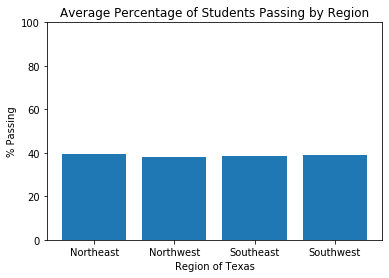

In [71]:
# Define series to by plotted on barchart

quadrant=avgpass_df['Quadrant']
percpass=avgpass_df['% Pass']

# Create bar chart of % Passing by Region

fig, ax=plt.subplots()

bar=plt.bar(x=quadrant, height=percpass)

# Include Title and axis labeling
plt.title('Average Percentage of Students Passing by Region')
plt.xlabel('Region of Texas')
plt.ylabel('% Passing')
ax.set_xticks(['NE', 'NW', 'SE', 'SW'])
ax.set_xticklabels(['Northeast', 'Northwest','Southeast','Southwest'])
plt.ylim(0,100)


### Now I create boxplot of the distribution of the % Pass by quadrant

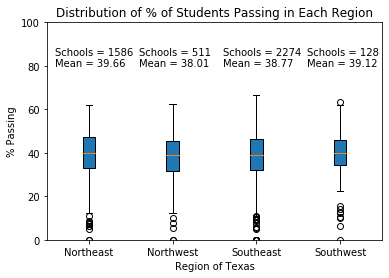

In [78]:

# Define series of % Pass for each quadrant
northeast=grade3all_df['% Pass'][grade3all_df['Quadrant']=='NE']
northwest=grade3all_df['% Pass'][grade3all_df['Quadrant']=='NW']
southeast=grade3all_df['% Pass'][grade3all_df['Quadrant']=='SE']
southwest=grade3all_df['% Pass'][grade3all_df['Quadrant']=='SW']

len_ne=len(northeast)
len_nw=len(northwest)
len_se=len(southeast)
len_sw=len(southwest)

mean_ne = northeast.mean()
mean_nw = northwest.mean()
mean_se = southeast.mean()
mean_sw = southwest.mean()

# Create the boxplots for each region
fig, ax=plt.subplots()

plt.boxplot(northeast, positions=[1], patch_artist=True)
plt.boxplot(northwest, positions=[2], patch_artist=True)
plt.boxplot(southeast, positions=[3], patch_artist=True)
plt.boxplot(southwest, positions=[4], patch_artist=True)

# Add some labeling and title
plt.title("Distribution of % of Students Passing in Each Region")
ax.set_xticklabels(['Northeast', 'Northwest','Southeast','Southwest'])
plt.ylim(0,100)
plt.xlabel('Region of Texas')
plt.ylabel('% Passing')
ax.text(0.6,85,f"Schools = {len_ne}")
ax.text(1.6,85,f"Schools = {len_nw}")
ax.text(2.6,85,f"Schools = {len_se}")
ax.text(3.6,85,f"Schools = {len_sw}")
ax.text(0.6,80,f"Mean = {round(mean_ne,2)}")
ax.text(1.6,80,f"Mean = {round(mean_nw,2)}")
ax.text(2.6,80,f"Mean = {round(mean_se,2)}")
ax.text(3.6,80,f"Mean = {round(mean_sw,2)}")

# plt.savefig('../reports/SchoolRegionBoxplot.png')

<Figure size 432x288 with 0 Axes>

### In the next cell, I will choose a random sample of 1000 schools and then use the latitude and longitude of each to do a Google Places search to identify if there is a university with 5 Kilometers from the school.  The reason for doign sampling was the API search can be very time consuming, so decided to work on smaller batch.
### The hypothesis is that schools that are near universites may have higher scores, since the children's parents might be more educated, which would then result in their children being better students. 

In [86]:
# Create a random number between 1 and 5000 for each row (ie. school) in datatable
grade3all_df['random']=np.random.randint(1,5000, (len(grade3all_df),1))

# Sort the datatable by the random number.  This will put the schools in a random order
grade3all_df.sort_values(by='random')

# Take the first 1000 schools. Since they are in a random order, this will give a random sample
# Note that I ran this code and output the results to a csv file for later use, so the full API
# call would not have to be repeated.  I then commented this out and added the following line
# which uses a much smaller set of data, so it can be run without taking too long
# 
grade3random_df=grade3all_df[:1000]

# This shorter version can be used for testing the API call
grade3random_df=grade3all_df[:10]


#add columns to hold the results of a search for nearby universities

grade3random_df['university'] = 0

# define base url for goodle maps
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

# Iterate over rows in dataframe
for index, row in grade3random_df.iterrows():

    # define parameters for request
    
    # Define location string that holds cooridinates of school to be passed to google maps
    location = str(grade3random_df.loc[index, 'Latitude']) + ',' + str(grade3random_df.loc[index,'Longitude'])
    target_radius2=5000
    type2='university'
   
    params1 = {
    "location": location,
    "type": type2,
    "radius" : target_radius2,
    "key": gkey,
    }
        
    response = requests.get(base_url, params=params1)

    response_json=response.json()
    
    # Check the status of the resonse.  If OK, it means that it found a university in the area
    # and the university column is changed to 1
    
    univstatus=response_json['status']
    if univstatus == "OK":
        grade3random_df.loc[index, 'university'] = 1    
        
    
# Output the results to a csv so they can be read back in and the API call doesn't need to be replaced
# Once this file was output, I commented this next line out so it would not be overwritten
 
# grade3random_df.to_csv('../cleandata/grade3_univdata.csv')


C:\Users\jeickholt\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jeickholt\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Read in the csv file that was saved

In [74]:
grade3random_df = pd.read_csv('../cleandata/grade3_univdata.csv')
len(grade3random_df)

1000

### In the next cell, I create a boxplot of the distribtion of % Pass for schools that are not near a university and schools that are near a university. I also do a ttest to compare the two groups and include the p-value on the plot

The t-statisic is -2.8105119896308155 and the p-value is 0.005184948980354879


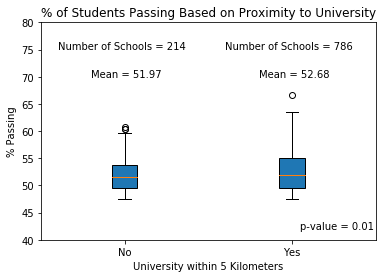

In [77]:
# Define series of % Pass for each quadrant
universityno=grade3random_df['% Pass'][grade3random_df['university']==0]
universityyes=grade3random_df['% Pass'][grade3random_df['university']== 1]

# Define number of schools that are or are not near a university 
lenno=len(universityno)
lenyes=len(universityyes)
meanno=universityno.mean()
meanyes=universityyes.mean() 

# Calculate the t-statistic and p-value
(t_stat, p) = ttest_ind(universityno, universityyes, equal_var=False)

print(f"The t-statisic is {t_stat} and the p-value is {p}")

# Create the boxplots for each region
fig, ax=plt.subplots()

plt.boxplot(universityno, positions=[1], patch_artist=True)
plt.boxplot(universityyes, positions=[2], patch_artist=True)

# Add some labeling and a title
plt.title("% of Students Passing Based on Proximity to University")
ax.set_xticklabels(['No', 'Yes'])
plt.ylim(40,80)
plt.xlabel('University within 5 Kilometers')
plt.ylabel('% Passing')
ax.text(0.6,75,f"Number of Schools = {lenno}")
ax.text(1.6,75,f"Number of Schools = {lenyes}")
ax.text(0.8, 70, f"Mean = {round(meanno,2)}")
ax.text(1.8, 70, f"Mean = {round(meanyes,2)}")
ax.text(2.05, 42, f"p-value = {round(p,2)}")

# plt.savefig('../reports/SchoolsUnivBoxPlot.png')